<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/Devito_numerical_solver_to_generate_solution_to_1D_Burgers'_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install devito &> /dev/null

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from devito import Grid, TimeFunction, first_derivative, left
from devito import Operator, Constant, Eq, solve

In [ ]:
nu = 0.01/np.pi # viscosity constant

nx = 1001 # no. x grid pts

T = 1 # total duration

# nt = 1001 # no. y (t) grid pts

# dt = T / (nt-1) # time step

dx = 2. / (nx-1) # distance step

sigma = .00009

# dt = sigma * dx / nu #* dy 

dt = 1e-4

nt = int((T / dt) + 1)

print(f'dx: {dx}\ndt: {dt}\nT: {dt*(nt-1)}')

nt

dx: 0.002
dt: 0.0001
T: 1.0


10001

In [ ]:
grid = Grid(shape=(nx), extent=(2.))
x = grid.dimensions
t = grid.stepping_dim

In [ ]:
u = TimeFunction(name='u', grid=grid, space_order=2)#, save=100)
u.data.shape

(2, 1001)

In [ ]:
a = Constant(name='a')
eq_u = Eq(u.dt + u*u.dxl, a*u.dx2)#, subdomain=grid.interior)
# eq_u

In [ ]:
stencil_u = solve(eq_u, u.forward)
# stencil_u

In [ ]:
update_u = Eq(u.forward, stencil_u)
# update_u

In [ ]:
bc_u = [Eq(u[t+1, 0], 0.)]  # left
bc_u += [Eq(u[t+1, nx-1], 0.)]  # right
bc_u

[Eq(u[t + 1, 0], 0.0), Eq(u[t + 1, 1000], 0.0)]

In [ ]:
op = Operator([update_u] + bc_u)

In [ ]:
u.data[:] = 0
# u.data[0,10:20] = 2
dummyX = np.arange(-1, 1+dx, dx)
u.data[0] = -1 * np.sin(np.pi * dummyX)

In [ ]:
batchSize = 100

results = np.zeros((nx, int(nt/batchSize)))
results[:,0] = u.data[0].copy()
results.shape

for timeStep in range(1, int(nt/batchSize)):    
    summary = op.apply(time=batchSize, dt=dt, a=nu)
    results[:,timeStep] = u.data[0].copy()

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator

In [ ]:
xPlot = np.array([i*dt*batchSize for i in range(int(nt/batchSize))])
yPlot = np.array([i*dx for i in range(int(nx))])
X, Y = np.meshgrid(xPlot,yPlot)
print(X.shape)
print(Y.shape)
results.shape

(1001, 100)
(1001, 100)


(1001, 100)

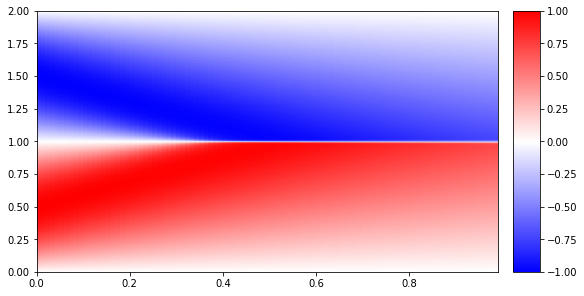

In [ ]:
fig, ax = plt.subplots(
    figsize=(8, 4),
    constrained_layout=True
    )
# gs = GridSpec(3, 10, figure=fig)

# solutionPlot = fig.add_subplot(gs[:2,:5])
cf = ax.pcolormesh(X,Y,results, cmap='bwr')

fig.colorbar(cf, ax=ax)